In [251]:
import csv
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

### Triplet Margin Loss
#### a: anchor, p: positive, n:negative
#### loss = log(sum((a-p)\*\*2)) - log(sum((a-n)\*\*2)) + margin


In [316]:
class TripletNet(nn.Module):
    def __init__(self):
        super(TripletNet, self).__init__() 
        self.weight = torch.ones(4096, requires_grad=True)
        #self.loss_fn = nn.TripletMarginLoss(margin=1.0, p=2)
        self.optimizer = torch.optim.Adam([self.weight], lr=1e-4)
        self.loss= None
    
    def forward(self, x, y, z):
        x = self.weight * x
        y = self.weight * y
        z = self.weight * z
        return self.loss_fn(x, y, z)
    
    def loss_fn(self, x, y, z):
        margin = 1
        reg = 1e-6
        loss = torch.log((x-y).pow(2).sum()) - torch.log((x-z).pow(2).sum()) + margin #+ reg * self.weight.abs().mean()
        return F.relu(loss)
    
    def train(self, x, y, z):
        self.loss = self.forward(x, y, z)
        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()

In [317]:
with open('data/gt_train.csv', 'r') as f:
    reader = csv.reader(f)
    gt = [int(y)+1 for x, y in list(reader)]

In [ ]:
tnet = TripletNet()
path = '/Workspace/task_train/' 
for epoch in range(100):
    for _ in range(17388): #17388
        i = np.random.randint(17388)
        folder = '0' * (9 - len(str(i))) + str(i) + '/'
        onehot = np.load(path + folder + 'one_hot.npy')
        ind = [j for j in range(1,11) if j!=gt[i]][np.random.randint(9)]
        x = torch.from_numpy(onehot[0,:]).float()
        y = torch.from_numpy(onehot[gt[i],:]).float()
        z = torch.from_numpy(onehot[ind,:]).float()
        tnet.train(x, y, z)
    print(tnet.loss)
    print(tnet.weight.sum())

In [319]:
np.save('data/tnet_w.npy', tnet.weight.detach().numpy())

In [320]:
path = '/Workspace/task_train/'
weight = np.load('data/tnet_w.npy')

niv_pos_dis = np.zeros(17388)
niv_neg_dis = np.zeros((17388, 9))
mlr_pos_dis = np.zeros(17388)
mlr_neg_dis = np.zeros((17388, 9))

for i in range(17388):
    folder = '0' * (9 - len(str(i))) + str(i) + '/'
    onehot = np.load(path + folder + 'one_hot.npy')
    niv_pos_dis[i] = ((onehot[gt[i],:] - onehot[0,:])**2).sum()
    niv_neg_dis[i,:] = ((onehot[[j for j in range(1,11) if j!=gt[i]],:] - onehot[0,:])**2).sum(axis=1)
    mlr_pos_dis[i] = ((weight * (onehot[gt[i],:] - onehot[0,:]))**2).sum()
    mlr_neg_dis[i,:] = ((weight * (onehot[[j for j in range(1,11) if j!=gt[i]],:] - onehot[0,:]))**2).sum(axis=1)

### Naive Log Square Error distance and accuracy (blue for positive, red for negative)

Accuracy:  0.19950540602714517


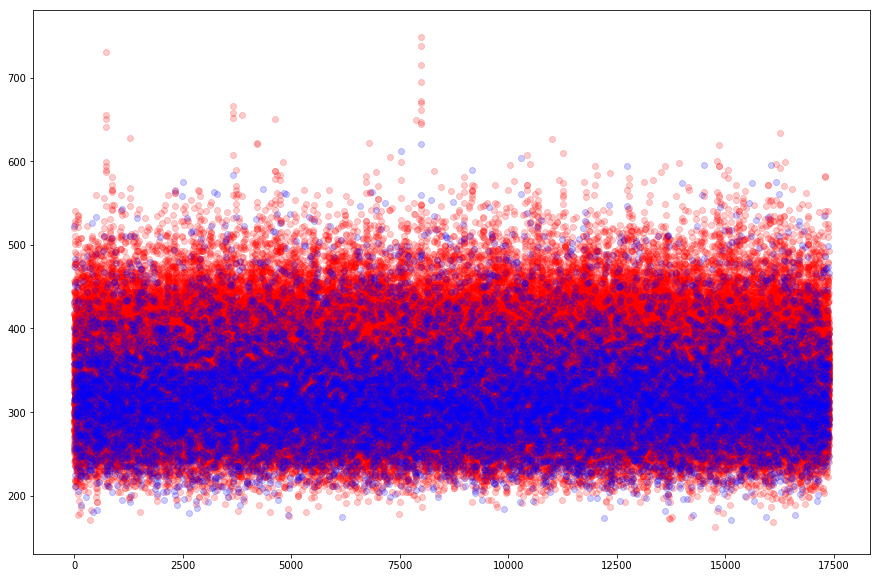

In [323]:
plt.figure(figsize=(15,10))
for i in range(9):
    plt.scatter(X, niv_neg_dis[:,i], c='r', alpha=0.2)
plt.scatter(X, niv_pos_dis, c='b', alpha=0.2)

print("Accuracy: ", np.sum(niv_neg_dis.min(axis=1)>niv_pos_dis)/niv_pos_dis.shape[0])

### Learned Log Square Error distance and accuracy (blue for positive, red for negative)

Accuracy:  0.2428686450425581


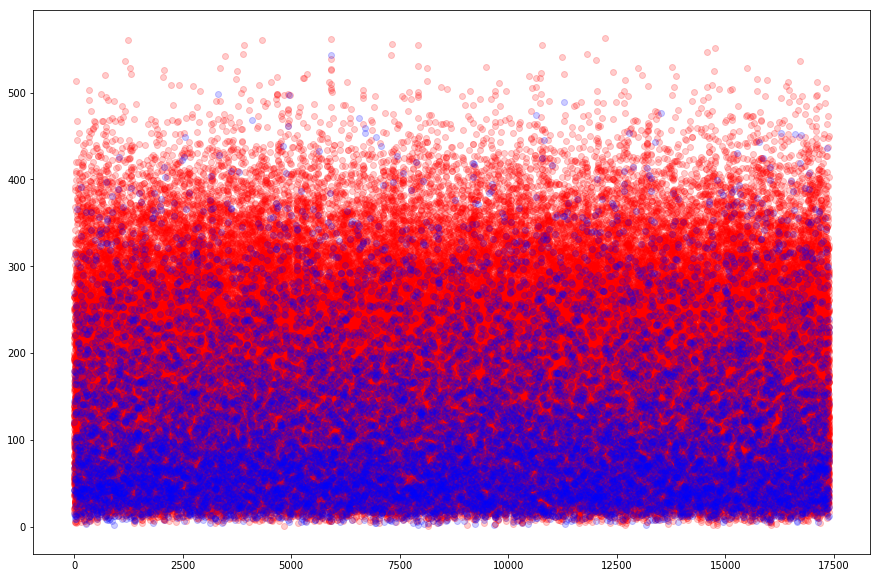

In [324]:
plt.figure(figsize=(15,10))
for i in range(9):
    plt.scatter(X, mlr_neg_dis[:,i], c='r', alpha=0.2)
plt.scatter(X, mlr_pos_dis, c='b', alpha=0.2)

print("Accuracy: ", np.sum(mlr_neg_dis.min(axis=1)>mlr_pos_dis)/niv_pos_dis.shape[0])